In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
dataset_obama = pd.read_csv("../datasets/obamaAnonimized.csv", dtype=str)

In [4]:
endorsers_percentage_list = pd.read_csv("../datasets/obama_endorsers_hours_percentage_list.csv", dtype=int, header=None)
endorsers_percentage_list = endorsers_percentage_list.values.tolist()
endorsers_percentage_list = [item for sublist in endorsers_percentage_list for item in sublist]

In [5]:
print(len(endorsers_percentage_list))

4730


In [6]:
# Tolgo 1 in quanto considero la prima epoca come lo stato iniziale
epochs = len(endorsers_percentage_list) - 1

In [7]:
print(len(dataset_obama))

4337


In [8]:
n_nodes = 2678
n_nodes

2678

In [9]:
n_bots = round((1 / 100) * n_nodes)
n_bots

27

In [10]:
n_fact_checkers = round((1 / 100) * n_nodes)
n_fact_checkers

27

In [11]:
n_influencers = 29

In [12]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

2595

In [13]:
n_initial_infected_nodes = round((1 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

0

# Validation for homophily 0.75

In [14]:
# Prendo i parametri calibrati con un dataset diverso da quello usato per la validazione
parameters_homophily_075 = pd.read_csv("./parameters/parameters_optimization_palin_hours_homophily_0.75.csv")

In [15]:
parameters_homophily_075 = parameters_homophily_075.sort_values(by='rmse')
parameters_homophily_075

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
16,0.50,0.33,0.75,0.024295,0.238505,0.627572,0.860890,0.610532,3.607667
13,0.33,0.50,0.75,0.452849,0.038784,0.725085,0.488359,0.459757,8.837733
12,0.33,0.33,0.75,0.559446,0.046271,0.904621,0.743159,0.947966,9.870279
15,0.50,0.25,0.75,0.694408,0.272079,0.278570,0.922379,0.023372,10.684394
9,0.25,0.75,0.75,0.519945,0.497827,0.484554,0.915505,0.984425,11.336427
17,0.50,0.50,0.75,0.200498,0.940240,0.054724,0.935212,0.154635,13.844171
7,0.25,0.33,0.75,0.360210,0.127941,0.252209,0.818803,0.870347,14.616534
19,0.75,0.25,0.75,0.274410,0.260870,0.917187,0.625798,0.728559,14.684150
8,0.25,0.50,0.75,0.005588,0.224918,0.040319,0.514692,0.895134,17.066942
11,0.33,0.25,0.75,0.455895,0.331393,0.054083,0.965285,0.581391,18.668095


In [16]:
alpha = parameters_homophily_075['alpha'].iloc[0]
beta = parameters_homophily_075['beta'].iloc[0]
homophily = parameters_homophily_075['homophily'].iloc[0]
prob_infection = parameters_homophily_075['prob_infection'].iloc[0]
prob_vaccination = parameters_homophily_075['prob_vaccination'].iloc[0]
prob_cure = parameters_homophily_075['prob_cure'].iloc[0]
prob_influencer = parameters_homophily_075['prob_influencer'].iloc[0]
prob_echo = parameters_homophily_075['prob_echo'].iloc[0]

In [17]:
container = NetworksContainer(n_networks=30, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=0.0, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

In [18]:
total_y_pred_list_homophily_075 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_homophily_075.append(y_pred_list)

In [19]:
avg_y_pred_list_homophily_075 = [sum(column) / len(column) for column in zip(*total_y_pred_list_homophily_075)]

In [20]:
std_y_pred_list_homophily_075 = [np.std(column) for column in zip(*total_y_pred_list_homophily_075)]

In [21]:
std_low_y_pred_list_homophily_075 = []
std_high_y_pred_list_homophily_075 = []
for i in range(len(avg_y_pred_list_homophily_075)):
    std_low_y_pred_list_homophily_075.append(avg_y_pred_list_homophily_075[i] - std_y_pred_list_homophily_075[i])
    std_high_y_pred_list_homophily_075.append(avg_y_pred_list_homophily_075[i] + std_y_pred_list_homophily_075[i])

In [22]:
x = []
for i in range(len(endorsers_percentage_list)):
    x.append(i)

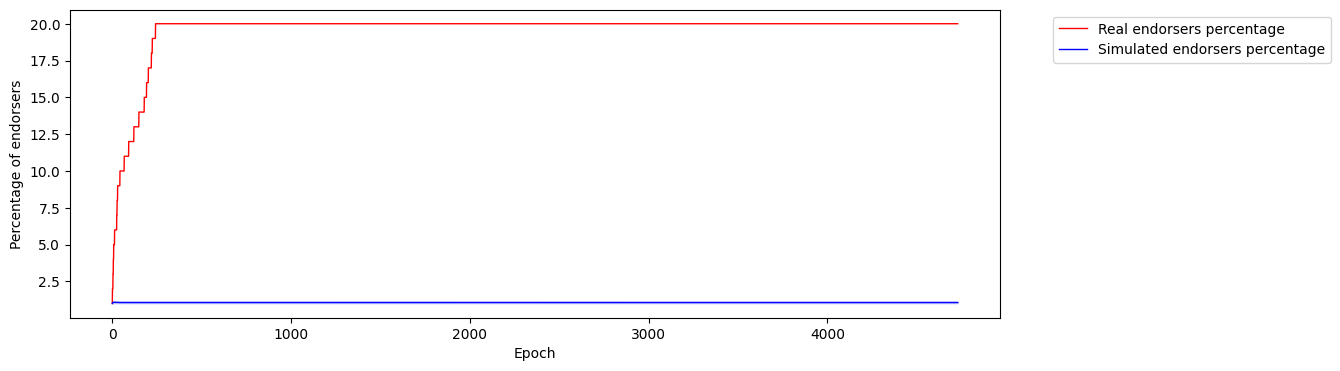

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list, c='r', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_homophily_075, c='b', label='Simulated endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_homophily_075, std_low_y_pred_list_homophily_075, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_homophily_075, std_high_y_pred_list_homophily_075, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [24]:
x = []
endorsers_percentage_list_truncated = []
avg_y_pred_list_homophily_075_truncated = []
std_low_y_pred_list_homophily_075_truncated = []
std_high_y_pred_list_homophily_075_truncated = []
for i in range(500):
    x.append(i)
    endorsers_percentage_list_truncated.append(endorsers_percentage_list[i])
    avg_y_pred_list_homophily_075_truncated.append(avg_y_pred_list_homophily_075[i])
    std_low_y_pred_list_homophily_075_truncated.append(std_low_y_pred_list_homophily_075[i])
    std_high_y_pred_list_homophily_075_truncated.append(std_high_y_pred_list_homophily_075[i])

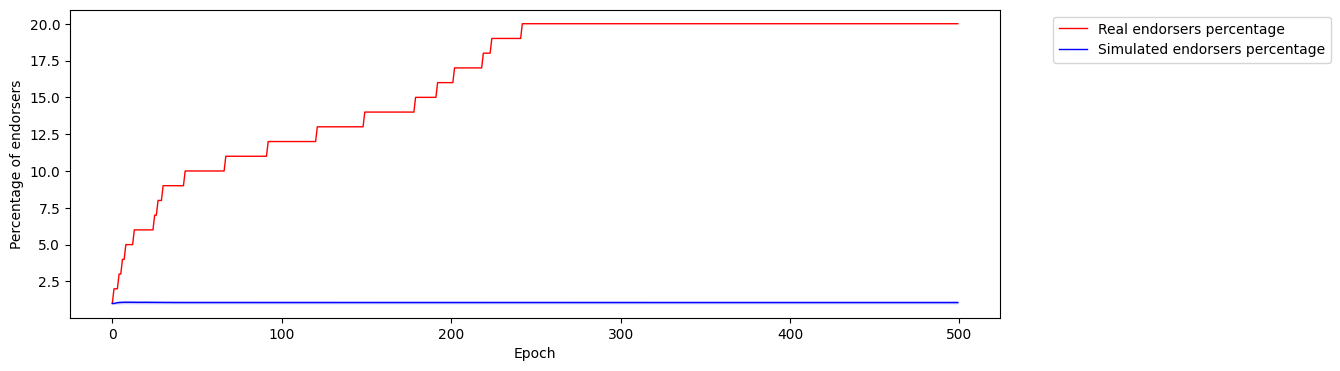

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list_truncated, c='r', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_homophily_075_truncated, c='b', label='Simulated endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_homophily_075_truncated, std_low_y_pred_list_homophily_075_truncated, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_homophily_075_truncated, std_high_y_pred_list_homophily_075_truncated, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [26]:
y_true = endorsers_percentage_list

neg_rmse_list_homophily_075 = []
for i in range(container.n_networks):
        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_homophily_075[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_homophily_075.append(neg_rmse)
    
mean_neg_rmse_homophily_075 = np.mean(neg_rmse_list_homophily_075)
std_neg_rmse_homophily_075 = np.std(neg_rmse_list_homophily_075)
print("Mean 0.75: ", mean_neg_rmse_homophily_075)
print("Standard deviation 0.75: ", std_neg_rmse_homophily_075)

Mean 0.75:  -18.6372126067517
Standard deviation 0.75:  0.06397081613772768


In [27]:
df_total_y_pred_list_homophily_075 = pd.DataFrame(total_y_pred_list_homophily_075).T
df_total_y_pred_list_homophily_075.to_csv("validation_obama_endorsers_percentages_homophily_0.75.csv", index=False, header=False)

In [28]:
df_statistics_homophily_075 = pd.DataFrame(avg_y_pred_list_homophily_075).T
df_statistics_homophily_075.loc[1] = std_y_pred_list_homophily_075
df_statistics_homophily_075.loc[2] = std_high_y_pred_list_homophily_075
df_statistics_homophily_075.loc[3] = std_low_y_pred_list_homophily_075
df_statistics_homophily_075.to_csv("validation_obama_statistics_homophily_0.75.csv", index=False, header=False)

In [29]:
df_rmse_homophily_075 = pd.DataFrame(neg_rmse_list_homophily_075).T
df_rmse_homophily_075.to_csv("validation_obama_rmse_homophily_0.75.csv", index=False, header=False)